In [1]:
from keras.models import load_model
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import sys
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import random
from torchvision import datasets
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import pickle

# Function to save Python object to a local file
def save_to_local(variable, filename):
    with open(filename, 'wb') as file:
        pickle.dump(variable, file)
    print(f"Saved {filename} successfully.")

In [3]:
from google.colab import files
def save_and_download_model(model, best_params, filename_prefix):
  """Saves the model's state dictionary and downloads it to the local machine.

  Args:
    model: The PyTorch model to save.
    best_params: A dictionary containing the best optimizer and learning rate.
    filename_prefix: A string prefix for the filename (e.g., 'ResNet18').
  """

  best_optimizer_name = best_params['optimizer']
  best_alpha = best_params['alpha']

  model_name = type(model).__name__
  filename = f"{filename_prefix}_{best_optimizer_name}_{best_alpha}.pth"

  torch.save(model.state_dict(), filename)
  files.download(filename)

## 1. Splitting Data and Data Pre-processing

In [5]:
# Define transformations for the transformed dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
trainval = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
testset = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# Get the labels from the dataset
labels = [label for _, label in trainval]

# Split the data into training and validation sets (80:20) with stratification
train_indices, val_indices = train_test_split(
    range(len(trainval)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create training and validation datasets
trainset = torch.utils.data.Subset(trainval, train_indices)
valset = torch.utils.data.Subset(trainval, val_indices)

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)  # For training
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=0)  # For validation
testloader = torch.utils.data.DataLoader(testset, batch_size= 64, shuffle=False, num_workers=0)  # For testing

# Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Show samples before and after transformation

Files already downloaded and verified


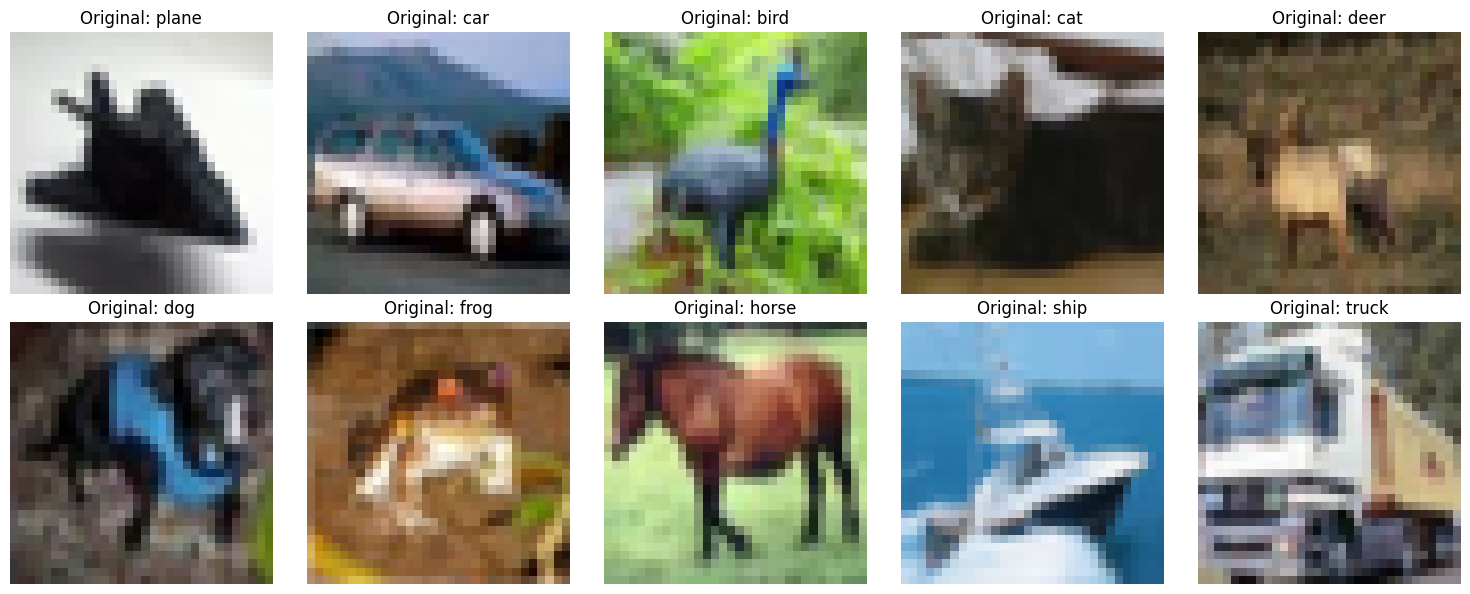

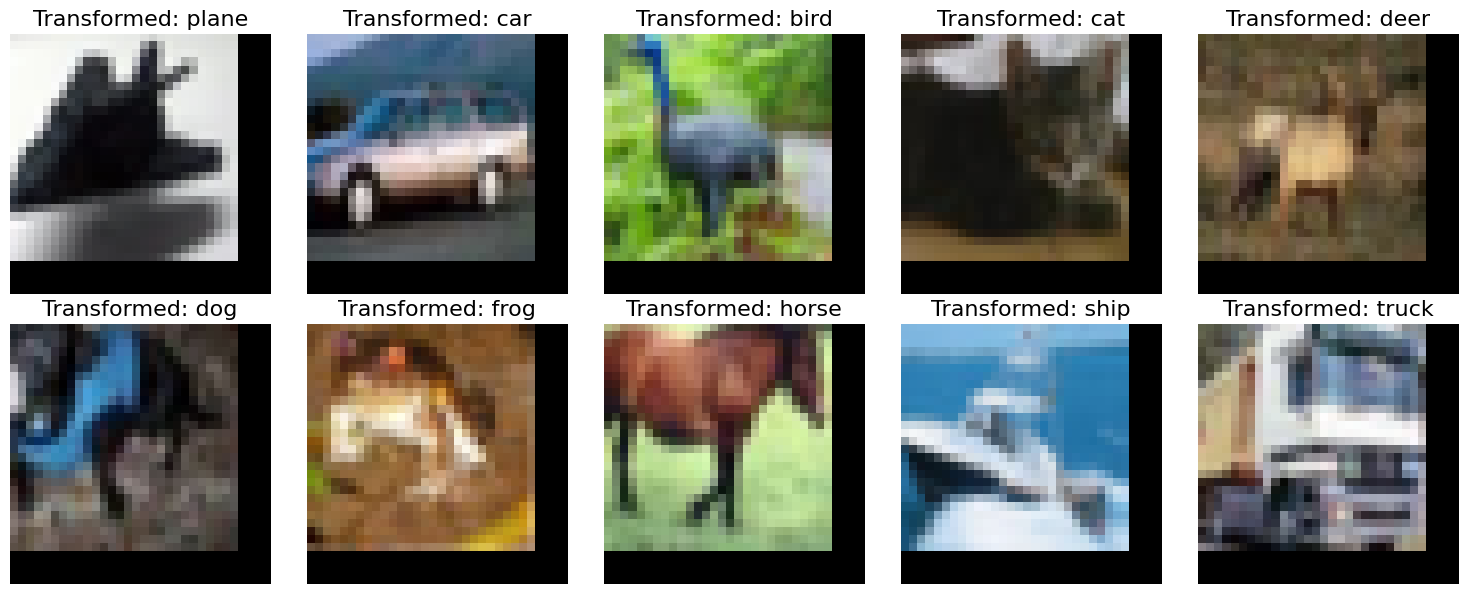

In [27]:
def show_original_and_transformed_samples(num_classes=10):
    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Load original CIFAR-10 dataset without transformations
    original_train_data = datasets.CIFAR10('data', train=True, download=True)

    # Define transformations
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Find one sample per class
    samples_per_class = {}
    for img, label in original_train_data:
        if label not in samples_per_class:
            samples_per_class[label] = img
        if len(samples_per_class) == num_classes:
            break

    # Plot the original images
    plt.figure(figsize=(15, 6))
    num_columns = 5
    num_rows = 2  # Two rows for the original images

    for i in range(num_classes):
        # Original image
        img = samples_per_class[i]
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(img)
        plt.title(f"Original: {classes[i]}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot the transformed images
    plt.figure(figsize=(15, 6))

    for i in range(num_classes):
        # Apply transformation
        torch.manual_seed(0)  # For reproducibility
        img = samples_per_class[i]
        transformed_img = transform(img)
        transformed_img = transformed_img.permute(1, 2, 0)  # Rearrange for plotting
        transformed_img = transformed_img * torch.tensor((0.2023, 0.1994, 0.2010)) + torch.tensor((0.4914, 0.4822, 0.4465))  # Undo normalization
        transformed_img = transformed_img.clamp(0, 1)  # Ensure values in range [0, 1]

        # Transformed image
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(transformed_img)
        plt.title(f"Transformed: {classes[i]}", fontsize=16)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display images
show_original_and_transformed_samples()


#### Show class distribution among sets

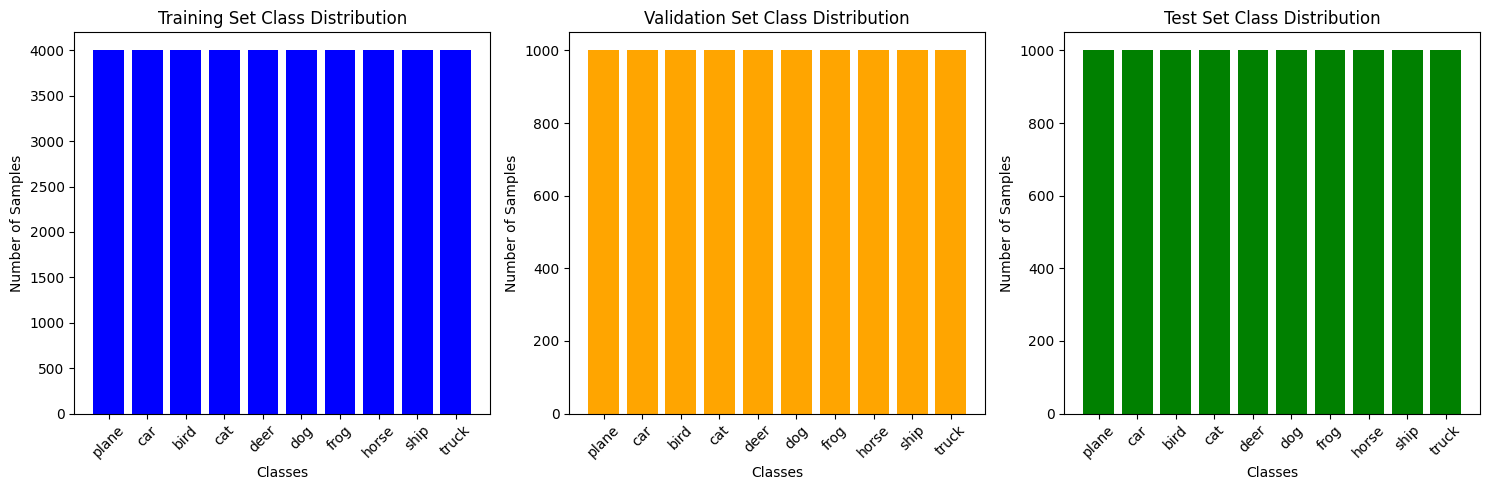

In [6]:
# Function to count class samples
def count_classes(dataset):
    class_counts = torch.zeros(10)  # CIFAR-10 has 10 classes
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

# Count classes in each dataset
train_counts = count_classes(trainset)
val_counts = count_classes(valset)
test_counts = count_classes(testset)

# Plotting the counts
x = range(len(classes))

plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 3, 1)
plt.bar(x, train_counts.numpy(), color='blue')
plt.title('Training Set Class Distribution')
plt.xticks(x, classes, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

# Validation set
plt.subplot(1, 3, 2)
plt.bar(x, val_counts.numpy(), color='orange')
plt.title('Validation Set Class Distribution')
plt.xticks(x, classes, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

# Test set
plt.subplot(1, 3, 3)
plt.bar(x, test_counts.numpy(), color='green')
plt.title('Test Set Class Distribution')
plt.xticks(x, classes, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()


## 2. Data modeling

#### Functions for training the model

In [3]:
def set_seed(seed: int):
    """Set the random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


In [4]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        # torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler = None,
               grad_clip: float = None):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent exploding gradients.
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    if scheduler is not None:
        scheduler.step(train_loss)

    return train_loss, train_acc


def validate_step(model: nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module):

    model.eval()
    val_loss, val_acc = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            y_pred_class = torch.argmax(y_pred, dim=1)
            val_acc += (y_pred_class == y).sum().item() / len(y)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    return val_loss, val_acc

In [5]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler = None,
                num_epochs: int = 70,
                grad_clip: float = None,
                early_stopping_patience: int = 10):  # Add early stopping patience

    # Initialize model weights
    model.apply(init_weights)

    best_val_loss = float('inf')

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):

        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, scheduler, grad_clip)
        val_loss, val_acc = validate_step(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_save_path = 'best_model.pth'
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved at epoch {epoch + 1} with Val Loss: {val_loss:.4f}")

        # Call early stopping and break if necessary
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}. Stopping training.")
            break

    return train_losses, train_accs, val_losses, val_accs

### 2.1 Baseline Model (ResNet18)

In [45]:
# Load ResNet-18 model and modify for CIFAR-10
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes, modify the final layer
resnet18 = resnet18.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.1)

# Define a learning rate scheduler with ReduceLROnPlateau
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [46]:
seed = 72  # You can choose any seed number
set_seed(seed)
resnet18_train_losses, resnet18_train_accs, resnet18_val_losses, resnet18_val_accs = train_model(resnet18, trainloader, valloader, loss_fn, optimizer, scheduler, num_epochs=70, grad_clip=None, early_stopping_patience=10)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/70, Train Loss: 2.1019, Train Acc: 0.3399, Val Loss: 1.9349, Val Acc: 0.3382
Model saved at epoch 1 with Val Loss: 1.9349
Epoch 2/70, Train Loss: 1.6029, Train Acc: 0.4575, Val Loss: 1.8762, Val Acc: 0.4408
Model saved at epoch 2 with Val Loss: 1.8762
Epoch 3/70, Train Loss: 1.4415, Train Acc: 0.5089, Val Loss: 2.4402, Val Acc: 0.4903
Epoch 4/70, Train Loss: 1.4211, Train Acc: 0.5181, Val Loss: 2.1799, Val Acc: 0.5040
Epoch 5/70, Train Loss: 1.2564, Train Acc: 0.5736, Val Loss: 1.4262, Val Acc: 0.5534
Model saved at epoch 5 with Val Loss: 1.4262
Epoch 6/70, Train Loss: 1.0917, Train Acc: 0.6134, Val Loss: 1.2226, Val Acc: 0.5778
Model saved at epoch 6 with Val Loss: 1.2226
Epoch 7/70, Train Loss: 0.9980, Train Acc: 0.6478, Val Loss: 1.3013, Val Acc: 0.5594
Epoch 8/70, Train Loss: 0.9335, Train Acc: 0.6679, Val Loss: 1.0956, Val Acc: 0.6117
Model saved at epoch 8 with Val Loss: 1.0956
Epoch 9/70, Train Loss: 0.8871, Train Acc: 0.6875, Val Loss: 0.9704, Val Acc: 0.6612
Model save

In [54]:
 # Finding the maximum accuracy and its corresponding epoch
best_baseline_val_acc = max(resnet18_val_accs)
best_baseline_epoch = resnet18_val_accs.index(best_baseline_val_acc ) + 1  # Adding 1 because epoch index starts from 0

print("Maximum validation accuracy:", best_baseline_val_acc)
print("Epoch with maximum accuracy:", best_baseline_epoch)

Maximum validation accuracy: 0.7959792993630573
Epoch with maximum accuracy: 52


In [50]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Plot training and validation losses
    plt.plot(epochs, train_losses, label="Training Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="orange")

    # Plot training and validation accuracies
    plt.plot(epochs, train_accs, label="Training Accuracy", color="green")
    plt.plot(epochs, val_accs, label="Validation Accuracy", color="red")

    plt.xlabel("Epochs")
    plt.ylabel("Metric Values")
    plt.title("Training and Validation Metrics of Baseline Model")
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()


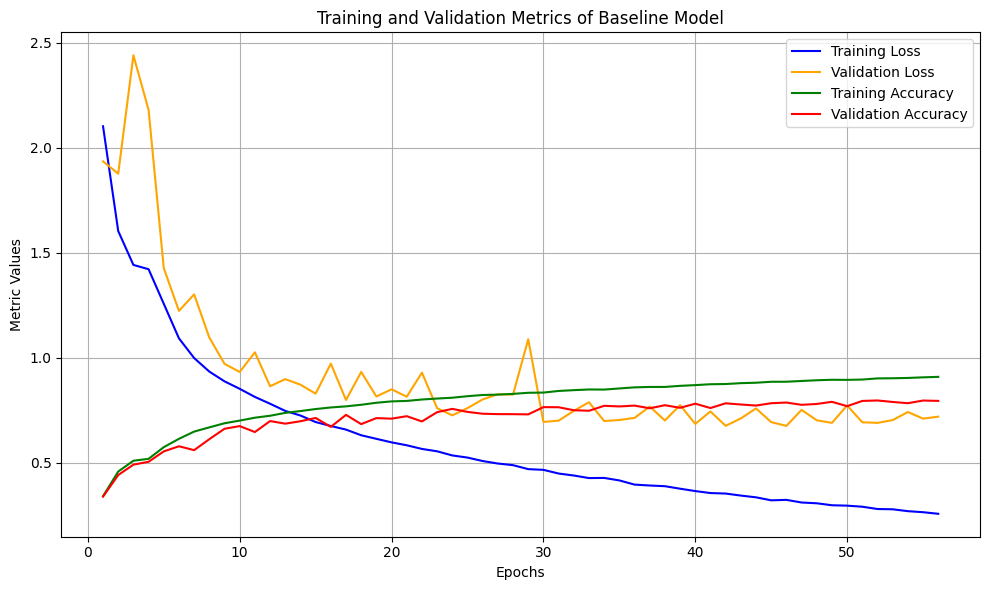

In [51]:
# Call the function with your ResNet-18 metrics
plot_metrics(resnet18_train_losses, resnet18_train_accs, resnet18_val_losses, resnet18_val_accs)


In [80]:
### Save the data
names = ['resnet18_train_losses', 'resnet18_train_accs', 'resnet18_val_losses', 'resnet18_val_accs']
for i, name in zip([resnet18_train_losses, resnet18_train_accs, resnet18_val_losses, resnet18_val_accs], names):
    save_to_local(i, f'{name}.pkl')

Saved resnet18_train_losses.pkl successfully.
Saved resnet18_train_accs.pkl successfully.
Saved resnet18_val_losses.pkl successfully.
Saved resnet18_val_accs.pkl successfully.


#### Optimisation functions

In [11]:
def learning_rate_optimization_new(model, trainloader, valloader, learning_rate_values, optimizers, num_epochs=70):
    best_params = {}
    best_val_loss = float('inf')

    # Initialize dictionaries to store metrics for each learning rate and optimizer
    history = {
        'train_losses': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'train_accs': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'val_losses': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'val_accs': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values}
    }

    for optimizer in optimizers:
        for alpha in learning_rate_values:
            print(f"Training with optimizer: {optimizer.__name__} and alpha: {alpha}")

            # Reset the model weights before each learning rate loop
            model.apply(init_weights)  # Ensure that init_weights is properly defined to reset weights

            # Define loss function
            loss_fn = torch.nn.CrossEntropyLoss()

            # Define optimizer based on the type specified
            if optimizer == torch.optim.SGD:
                optimizer_instance = optimizer(model.parameters(), lr=alpha, momentum=0.9, weight_decay=0.0001)
                grad_clip = 1
            elif optimizer == torch.optim.Adam:
                optimizer_instance = optimizer(model.parameters(), lr=alpha, weight_decay=1e-4)
                grad_clip = 0.1

            # Define learning rate scheduler - ReduceLROnPlateau based on validation loss
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_instance, mode='min', patience=3, factor=0.3, threshold=1e-2)

            # Initialize early stopping
            early_stopping = EarlyStopping(patience=10)

            # Training loop
            for epoch in range(num_epochs):
                # Train the model
                train_loss, train_acc = train_step(model, trainloader, loss_fn, optimizer_instance)

                # Apply gradient clipping, if grad_clip is specified
                # if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                # Perform optimizer step
                optimizer_instance.step()

                # Validate the model
                val_loss, val_acc = validate_step(model, valloader, loss_fn)

                # Store records in the dictionary for the current optimizer and learning rate
                key = f"{optimizer.__name__}_{alpha}"
                history['train_losses'][key].append(train_loss)
                history['train_accs'][key].append(train_acc)
                history['val_losses'][key].append(val_loss)
                history['val_accs'][key].append(val_acc)

                # Step the scheduler with validation loss
                scheduler.step(val_loss)

                # Check early stopping
                early_stopping(val_loss)

                # Print results for the current epoch
                print(f"Epoch {epoch + 1}/{num_epochs},a "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

                if early_stopping.early_stop:
                    print(f"Early stopping triggered at epoch {epoch + 1}. Stopping training.")
                    break

            # Record the best validation loss and parameters (inclzuding learning rate)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'optimizer': optimizer.__name__, 'alpha': alpha, 'best_lr': optimizer_instance.param_groups[0]['lr']}
                # print(f"Model saved at epoch {epoch + 1} with Val Loss: {val_loss:.4f}")

    # Print the best parameters
    print(f"Best parameters: {best_params}")

    return best_params, history


In [7]:

def learning_rate_optimization_new(model, trainloader, valloader, learning_rate_values, optimizers, num_epochs=70):
    best_params = {}
    best_val_loss = float('inf')
    best_model_state = None  # To store the state of the best model

    # Initialize dictionaries to store metrics for each learning rate and optimizer
    history = {
        'train_losses': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'train_accs': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'val_losses': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values},
        'val_accs': {f"{opt.__name__}_{alpha}": [] for opt in optimizers for alpha in learning_rate_values}
    }

    for optimizer in optimizers:
        for alpha in learning_rate_values:
            print(f"Training with optimizer: {optimizer.__name__} and alpha: {alpha}")

            # Reset the model weights before each learning rate loop
            model.apply(init_weights)  # Ensure that init_weights is properly defined to reset weights

            # Define loss function
            loss_fn = torch.nn.CrossEntropyLoss()

            # Define optimizer based on the type specified
            if optimizer == torch.optim.SGD:
                optimizer_instance = optimizer(model.parameters(), lr=alpha, momentum=0.9, weight_decay=0.0001)
                grad_clip = 1
            elif optimizer == torch.optim.Adam:
                optimizer_instance = optimizer(model.parameters(), lr=alpha, weight_decay=1e-4)
                grad_clip = 0.1

            # Define learning rate scheduler - ReduceLROnPlateau based on validation loss
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_instance, mode='min', patience=3, factor=0.3, threshold=1e-2)

            # Initialize early stopping
            early_stopping = EarlyStopping(patience=10)

            # Training loop
            for epoch in range(num_epochs):
                # Train the model
                train_loss, train_acc = train_step(model, trainloader, loss_fn, optimizer_instance)

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                # Perform optimizer step
                optimizer_instance.step()

                # Validate the model
                val_loss, val_acc = validate_step(model, valloader, loss_fn)

                # Store records in the dictionary for the current optimizer and learning rate
                key = f"{optimizer.__name__}_{alpha}"
                history['train_losses'][key].append(train_loss)
                history['train_accs'][key].append(train_acc)
                history['val_losses'][key].append(val_loss)
                history['val_accs'][key].append(val_acc)

                # Step the scheduler with validation loss
                scheduler.step(val_loss)

                # Check early stopping
                early_stopping(val_loss)

                # Print results for the current epoch
                print(f"Epoch {epoch + 1}/{num_epochs}, "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

                if early_stopping.early_stop:
                    print(f"Early stopping triggered at epoch {epoch + 1}. Stopping training.")
                    break

            # Record the best validation loss and parameters (including learning rate)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'optimizer': optimizer.__name__, 'alpha': alpha, 'best_lr': optimizer_instance.param_groups[0]['lr']}
                best_model_state = model.state_dict()  # Save the best model's state

                # Create a dynamic filename based on model architecture and parameters
                model_name = type(model).__name__  # Get the class name of the model
                filename = f"{model_name}_{optimizer.__name__}_{alpha}.pth"  # Create a unique filename
                torch.save(best_model_state, filename)  # Save the model's state_dict

    # Print the best parameters
    print(f"Best parameters: {best_params}")

    return best_params, history


In [8]:
def find_best_model(history, name):
    best_val_acc = 0
    best_key = ""
    best_epoch = 0

    # Iterate over the validation accuracies in the history
    for key in history['val_accs']:
        max_acc = max(history['val_accs'][key])
        epoch = history['val_accs'][key].index(max_acc)

        # Update if the current max accuracy is higher than the recorded best
        if max_acc > best_val_acc:
            best_val_acc = max_acc
            best_key = key
            best_epoch = epoch + 1  # Adding 1 for 1-indexed epoch reporting

    print(f"Best {name} Model: Optimizer & LR = {best_key}")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return best_key, best_epoch, best_val_acc

In [8]:

def plot_optimizer_results_combined(history, learning_rate_values, name):
    optimizers = ['SGD', 'Adam']
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows, 1 column of subplots

    colors = ['r', 'g', 'b', 'm']  # Add a fourth color for clarity
    line_styles = ['-', '--']  # Solid for train, dashed for val

    # Accuracy subplot
    ax_acc = axes[0]
    for idx, optimizer_name in enumerate(optimizers):
        for i, alpha in enumerate(learning_rate_values):
            key = f"{optimizer_name}_{alpha}"
            color = colors[idx * len(learning_rate_values) + i]  # Ensure unique color per combination
            ax_acc.plot(history['train_accs'][key], color=color, linestyle=line_styles[0],
                        label=f"{optimizer_name} Train Acc (lr={alpha})")
            ax_acc.plot(history['val_accs'][key], color=color, linestyle=line_styles[1],
                        label=f"{optimizer_name} Val Acc (lr={alpha})")

    ax_acc.set_title(f"{name} - Combined Accuracy")
    ax_acc.set_xlabel("Epochs")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.grid(True)
    ax_acc.legend()  # Combined legend for accuracy

    # Loss subplot
    ax_loss = axes[1]
    for idx, optimizer_name in enumerate(optimizers):
        for i, alpha in enumerate(learning_rate_values):
            key = f"{optimizer_name}_{alpha}"
            color = colors[idx * len(learning_rate_values) + i]  # Ensure unique color per combination
            ax_loss.plot(history['train_losses'][key], color=color, linestyle=line_styles[0],
                         label=f"{optimizer_name} Train Loss (lr={alpha})")
            ax_loss.plot(history['val_losses'][key], color=color, linestyle=line_styles[1],
                         label=f"{optimizer_name} Val Loss (lr={alpha})")

    ax_loss.set_ylim([0, 6])
    ax_loss.set_title(f"{name} - Combined Loss")
    ax_loss.set_xlabel("Epochs")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(True)
    ax_loss.legend()  # Combined legend for loss

    plt.tight_layout()  # Adjusts the padding between subplots
    plt.show()


### 2.2 ResNet Optimisation

In [16]:
seed = 42 # You can choose any seed number
set_seed(seed)
learning_rate_values = [0.1, 0.01]
optimizers = [torch.optim.SGD, torch.optim.Adam]
best_resnet_params, best_resnet_history = learning_rate_optimization_new(
    resnet18, trainloader, valloader, learning_rate_values, optimizers)

Training with optimizer: SGD and alpha: 0.1
Epoch 1/70, Train Loss: 2.3313, Train Acc: 0.2753, Val Loss: 1.8082, Val Acc: 0.3342
Epoch 2/70, Train Loss: 1.6309, Train Acc: 0.3979, Val Loss: 1.5659, Val Acc: 0.4293
Epoch 3/70, Train Loss: 1.4751, Train Acc: 0.4587, Val Loss: 1.4247, Val Acc: 0.4856
Epoch 4/70, Train Loss: 1.3749, Train Acc: 0.5015, Val Loss: 1.4626, Val Acc: 0.4745
Epoch 5/70, Train Loss: 1.2605, Train Acc: 0.5438, Val Loss: 1.2621, Val Acc: 0.5605
Epoch 6/70, Train Loss: 1.1712, Train Acc: 0.5817, Val Loss: 1.1471, Val Acc: 0.5908
Epoch 7/70, Train Loss: 1.0934, Train Acc: 0.6113, Val Loss: 1.1276, Val Acc: 0.6051
Epoch 8/70, Train Loss: 1.0226, Train Acc: 0.6370, Val Loss: 1.0129, Val Acc: 0.6376
Epoch 9/70, Train Loss: 0.9712, Train Acc: 0.6559, Val Loss: 0.9668, Val Acc: 0.6623
Epoch 10/70, Train Loss: 0.9238, Train Acc: 0.6737, Val Loss: 0.9308, Val Acc: 0.6814
Epoch 11/70, Train Loss: 0.8801, Train Acc: 0.6912, Val Loss: 0.9466, Val Acc: 0.6614
Epoch 12/70, Train 

In [20]:
best_resnet_key, best_resnet_epoch, best_resnet_val_acc = find_best_model(best_resnet_history, "ResNet18")

Best ResNet18 Model: Optimizer & LR = SGD_0.1
Best Epoch: 43
Best Validation Accuracy: 0.8184


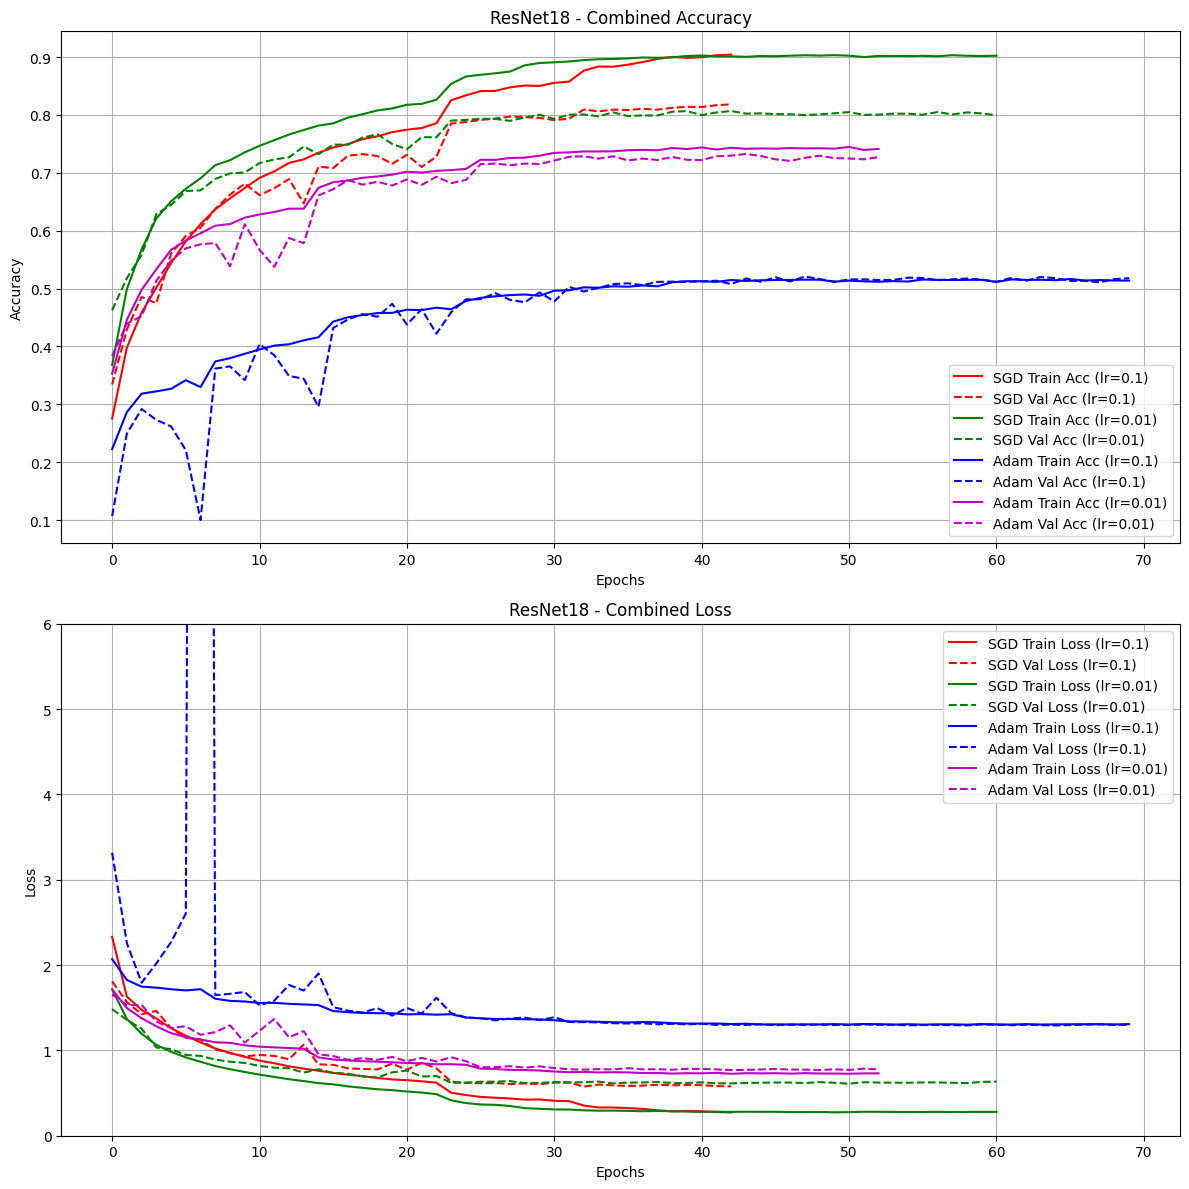

In [34]:
learning_rate_values = [0.1, 0.01]
plot_optimizer_results_combined(best_resnet_history, learning_rate_values, 'ResNet18')

In [28]:
names = ['best_resnet_params_new', 'best_resnet_history_new']
for i, name in zip([best_resnet_params, best_resnet_history], names):
    save_to_local(i, f'{name}.pkl')

Saved best_resnet_params_new.pkl successfully.
Saved best_resnet_history_new.pkl successfully.


In [30]:
save_and_download_model(resnet18, best_resnet_params, 'ResNet18')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.3 AlexNet optimisation

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdjustedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AdjustedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),  # Reduced fully connected layer size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),  # Output layer
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.classifier(x)
        return x


In [7]:
# Check device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Initialize the AlexNet model
# alexnet = AlexNet(num_classes=10).to(device)

# Initialize the adjusted AlexNet model
adjusted_alexnet = AdjustedAlexNet(num_classes=10).to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

In [16]:
seed = 42 # You can choose any seed number
set_seed(seed)
learning_rate_values = [0.1, 0.01]
optimizers = [torch.optim.SGD, torch.optim.Adam]
best_alexnet_params, best_alexnet_history = learning_rate_optimization_new(
    adjusted_alexnet, trainloader, valloader, learning_rate_values, optimizers
)

Training with optimizer: SGD and alpha: 0.1
Epoch 1/70, Train Loss: 2.7071, Train Acc: 0.1478, Val Loss: 2.0872, Val Acc: 0.2149
Epoch 2/70, Train Loss: 2.0397, Train Acc: 0.2225, Val Loss: 1.8633, Val Acc: 0.2745
Epoch 3/70, Train Loss: 1.9179, Train Acc: 0.2606, Val Loss: 1.8280, Val Acc: 0.2605
Epoch 4/70, Train Loss: 1.8432, Train Acc: 0.2991, Val Loss: 1.7155, Val Acc: 0.3527
Epoch 5/70, Train Loss: 1.7229, Train Acc: 0.3483, Val Loss: 1.5895, Val Acc: 0.4044
Epoch 6/70, Train Loss: 1.6360, Train Acc: 0.3852, Val Loss: 1.7491, Val Acc: 0.3751
Epoch 7/70, Train Loss: 1.5624, Train Acc: 0.4177, Val Loss: 1.6539, Val Acc: 0.4264
Epoch 8/70, Train Loss: 1.4927, Train Acc: 0.4533, Val Loss: 1.3973, Val Acc: 0.5004
Epoch 9/70, Train Loss: 1.4319, Train Acc: 0.4735, Val Loss: 1.4083, Val Acc: 0.4720
Epoch 10/70, Train Loss: 1.3786, Train Acc: 0.5022, Val Loss: 1.3462, Val Acc: 0.5136
Epoch 11/70, Train Loss: 1.3199, Train Acc: 0.5340, Val Loss: 1.2857, Val Acc: 0.5348
Epoch 12/70, Train 

In [19]:
best_alexnet_key, best_alexnet_epoch, best_alexnet_val_acc = find_best_model(best_alexnet_history, "AlexNet")

Best AlexNet Model: Optimizer & LR = SGD_0.01
Best Epoch: 35
Best Validation Accuracy: 0.8754


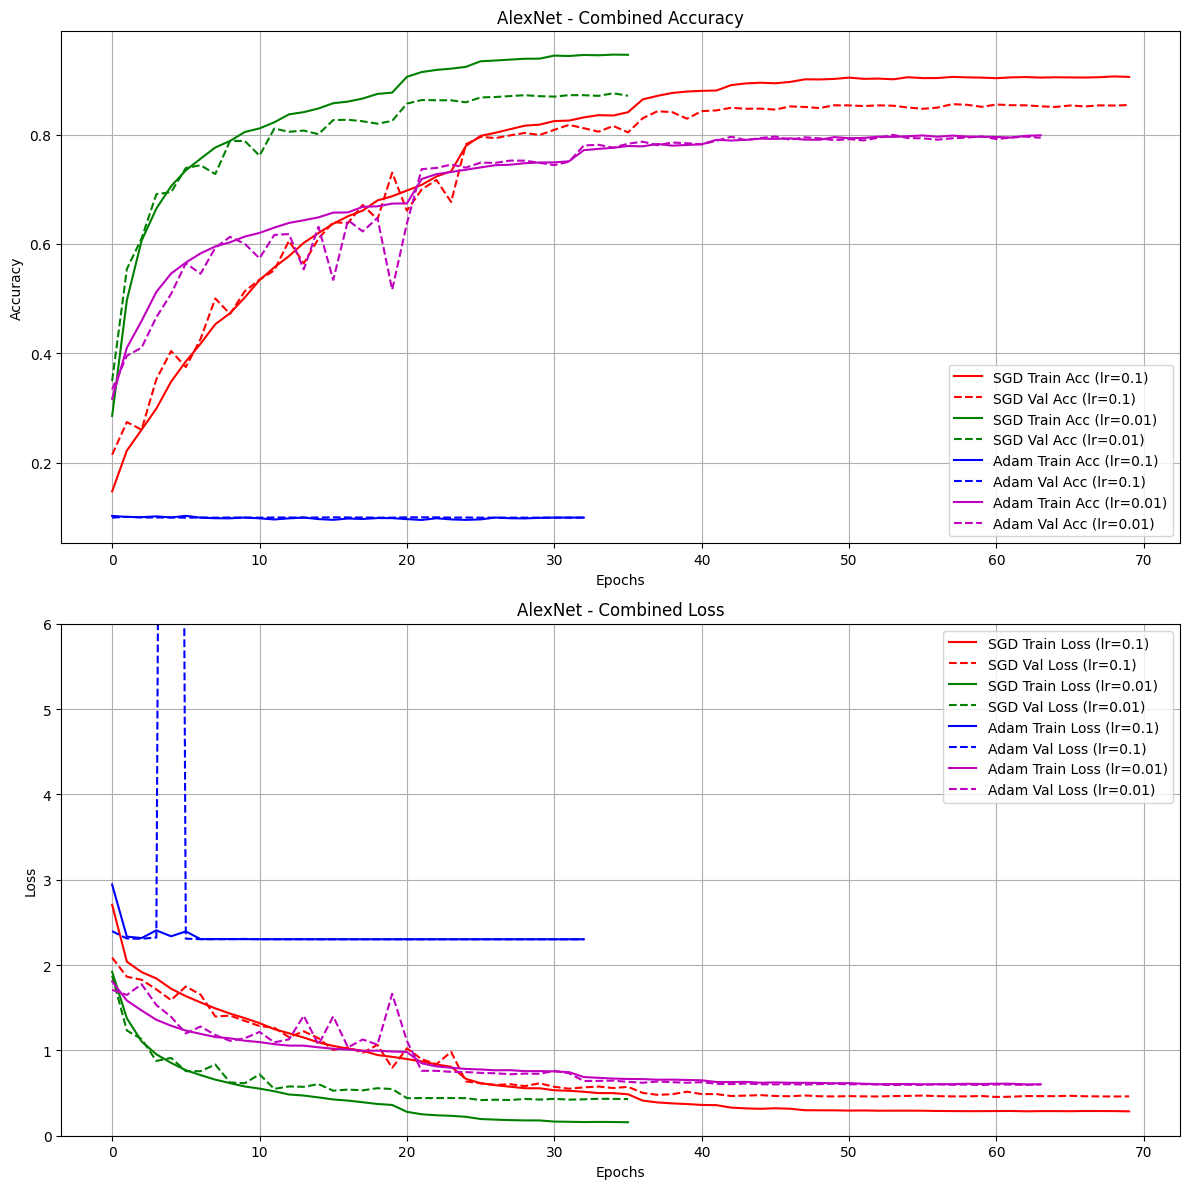

In [35]:
learning_rate_values = [0.1, 0.01]
plot_optimizer_results_combined(best_alexnet_history, learning_rate_values, "AlexNet")

In [23]:
names = ['best_alexnet_params', 'best_alexnet_history']
for i, name in zip([best_alexnet_params, best_alexnet_history], names):
    save_to_local(i, f'{name}.pkl')

Saved best_alexnet_params.pkl successfully.
Saved best_alexnet_history.pkl successfully.


In [31]:
save_and_download_model(adjusted_alexnet, best_alexnet_params, 'AdjustedAlexNet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.4 MobileNet Optimisation

In [38]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Adjusted for CIFAR-10
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            *[DepthwiseSeparableConv(512, 512) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [12]:
# Check device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the MobileNetV1 model for CIFAR-10
mobilenet = MobileNet(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()

In [13]:
seed = 42 # You can choose any seed number
set_seed(seed)
learning_rate_values = [0.1, 0.01]
optimizers = [torch.optim.SGD, torch.optim.Adam]
best_mobilenet_params, best_mobilenet_history = learning_rate_optimization_new(
    mobilenet, trainloader, valloader, learning_rate_values, optimizers
)

Training with optimizer: SGD and alpha: 0.1
Epoch 1/70, Train Loss: 2.3108, Train Acc: 0.2407, Val Loss: 1.8361, Val Acc: 0.3275
Epoch 2/70, Train Loss: 1.7433, Train Acc: 0.3548, Val Loss: 1.6787, Val Acc: 0.3862
Epoch 3/70, Train Loss: 1.6377, Train Acc: 0.4033, Val Loss: 1.6144, Val Acc: 0.4028
Epoch 4/70, Train Loss: 1.5481, Train Acc: 0.4342, Val Loss: 1.5186, Val Acc: 0.4482
Epoch 5/70, Train Loss: 1.4863, Train Acc: 0.4563, Val Loss: 1.4527, Val Acc: 0.4684
Epoch 6/70, Train Loss: 1.4611, Train Acc: 0.4722, Val Loss: 1.4787, Val Acc: 0.4682
Epoch 7/70, Train Loss: 1.4086, Train Acc: 0.4871, Val Loss: 1.4231, Val Acc: 0.4832
Epoch 8/70, Train Loss: 1.3611, Train Acc: 0.5091, Val Loss: 1.3797, Val Acc: 0.5070
Epoch 9/70, Train Loss: 1.4779, Train Acc: 0.4645, Val Loss: 1.4288, Val Acc: 0.4838
Epoch 10/70, Train Loss: 1.3874, Train Acc: 0.4972, Val Loss: 1.3695, Val Acc: 0.5037
Epoch 11/70, Train Loss: 1.3059, Train Acc: 0.5293, Val Loss: 1.3248, Val Acc: 0.5253
Epoch 12/70, Train 

In [39]:
best_mobilenet_key, best_mobilenet_epoch, best_mobilenet_val_acc = find_best_model(best_mobilenet_history, "MobileNet")

Best MobileNet Model: Optimizer & LR = SGD_0.01
Best Epoch: 44
Best Validation Accuracy: 0.7578


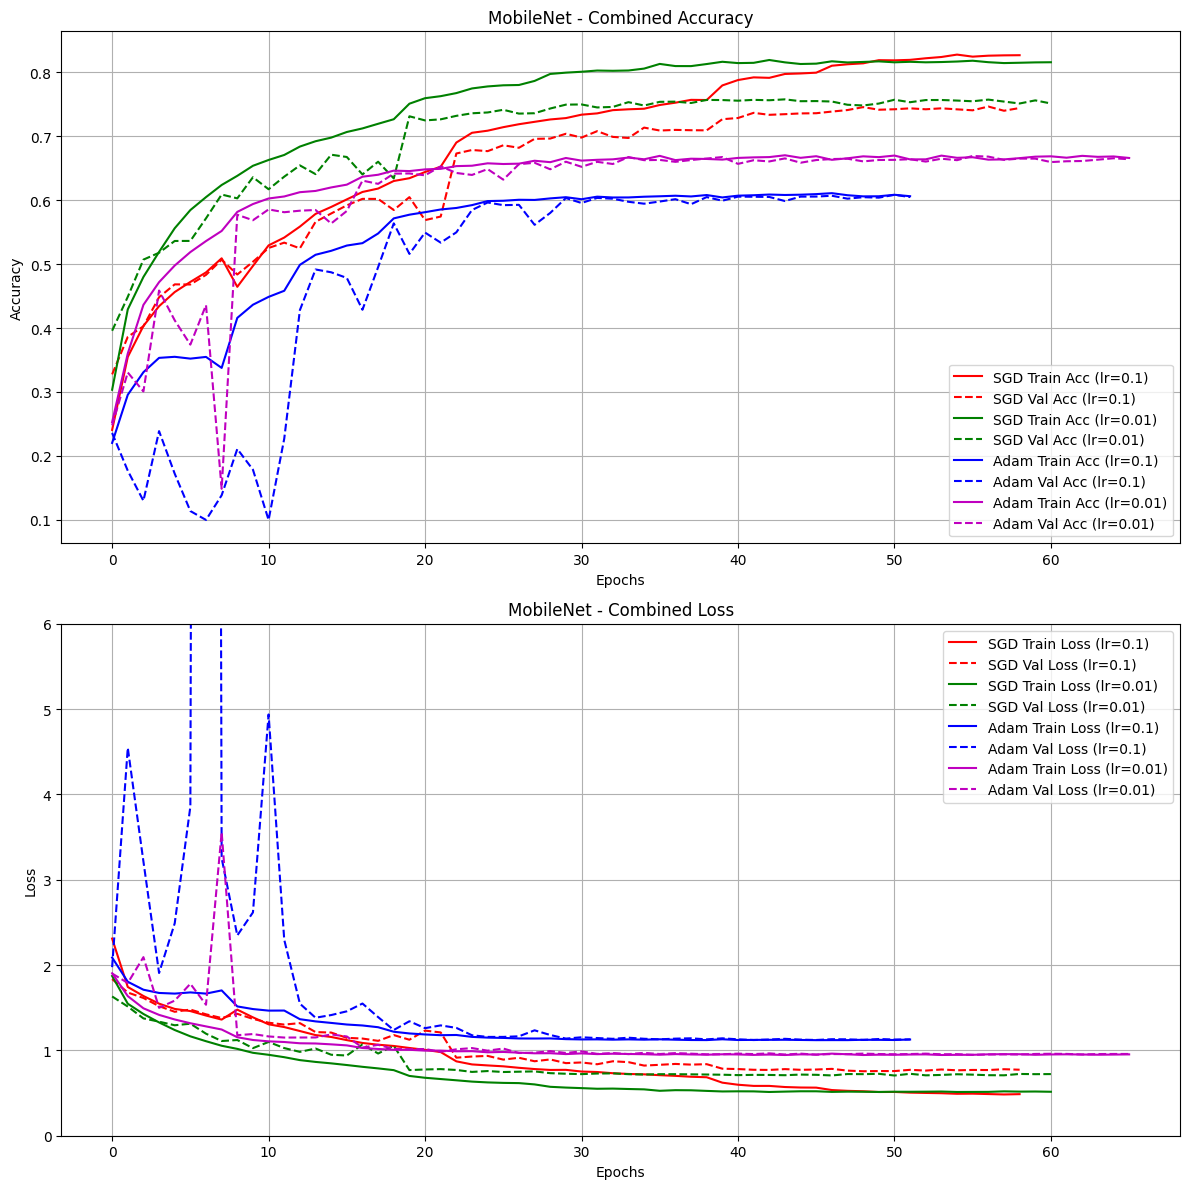

In [9]:
learning_rate_values = [0.1, 0.01]
plot_optimizer_results_combined(best_mobilenet_history, learning_rate_values, "MobileNet")

In [23]:
names = ['best_mobilenet_params', 'best_mobilenet_history']
for i, name in zip([best_mobilenet_params, best_mobilenet_history], names):
    save_to_local(i, f'{name}.pkl')

Saved best_mobilenet_params.pkl successfully.
Saved best_mobilenet_history.pkl successfully.


In [44]:
save_and_download_model(mobilenet, best_mobilenet_params, 'MobileNet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.5 Comparing baseline model and the best models of each architecture after optimisation

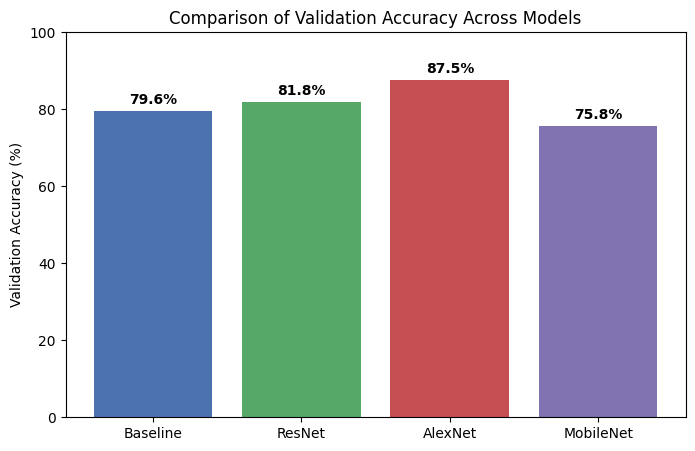

In [22]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
model_names = ['Baseline', 'ResNet', 'AlexNet', 'MobileNet']
accuracies = [best_baseline_val_acc * 100, best_resnet_val_acc * 100, best_alexnet_val_acc * 100, best_mobilenet_val_acc * 100]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])

# Display percentage values on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{acc:.1f}%", ha='center', va='bottom', fontweight='bold')

# Adding labels and title
plt.ylabel("Validation Accuracy (%)")
plt.title("Comparison of Validation Accuracy Across Models")
plt.ylim(0, 100)  # Set y-axis limit to 100% for clarity

plt.show()


## 3. Apply the best model on test set

The best model is AlexNet using SGD with learning rate 0.01

In [8]:
# Load the best AlexNet model checkpoint
alexnet = AdjustedAlexNet(num_classes=10).to(device)  # Assuming AlexNet is defined similarly to MobileNet
checkpoint = torch.load("AdjustedAlexNet_SGD_0.01.pth")  # Adjust the filename if necessary
alexnet.load_state_dict(checkpoint)

<ipython-input-8-97adf3681d40>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("AdjustedAlexNet_SGD_0.01.pth")  # Adjust the filename if necessary


<All keys matched successfully>

In [9]:
# Define evaluate_model_on_test_with_class_accuracy with confusion matrix calculation
def evaluate_model_on_test_with_class_accuracy(model, dataloader):
    model.eval()
    total_loss = 0
    total_correct = 0
    class_correct = [0] * 10
    class_total = [0] * 10

    all_labels = []
    all_predictions = []

    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

            # Accumulate labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

    # Calculate average test loss and overall test accuracy
    avg_test_loss = total_loss / len(dataloader)
    test_accuracy = total_correct / sum(class_total)

    # Calculate accuracy per class
    class_accuracies = {f"Class {i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)}

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return avg_test_loss, test_accuracy, class_accuracies, conf_matrix

Test Loss: 0.5842
Overall Test Accuracy: 0.7989
Accuracy per class:
Class 0: 79.00%
Class 1: 93.00%
Class 2: 65.80%
Class 3: 57.70%
Class 4: 74.70%
Class 5: 76.60%
Class 6: 88.80%
Class 7: 84.60%
Class 8: 89.40%
Class 9: 89.30%


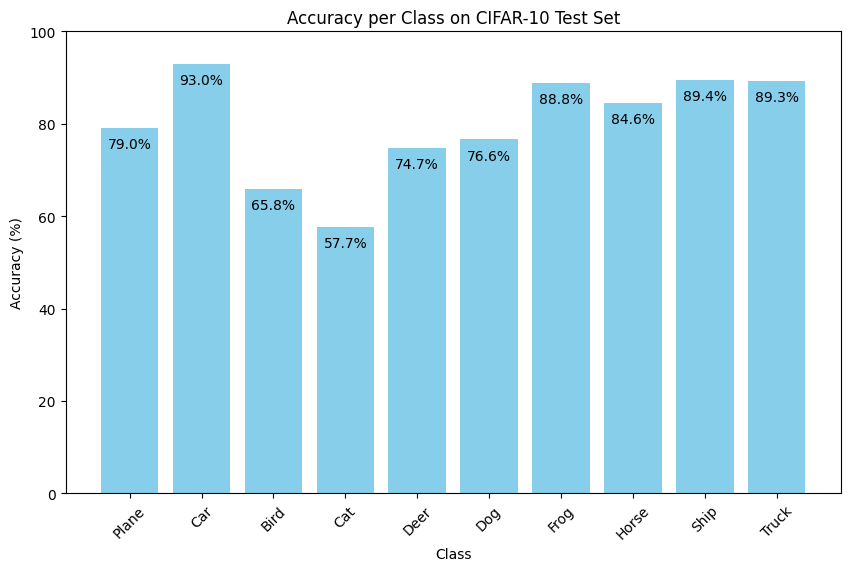

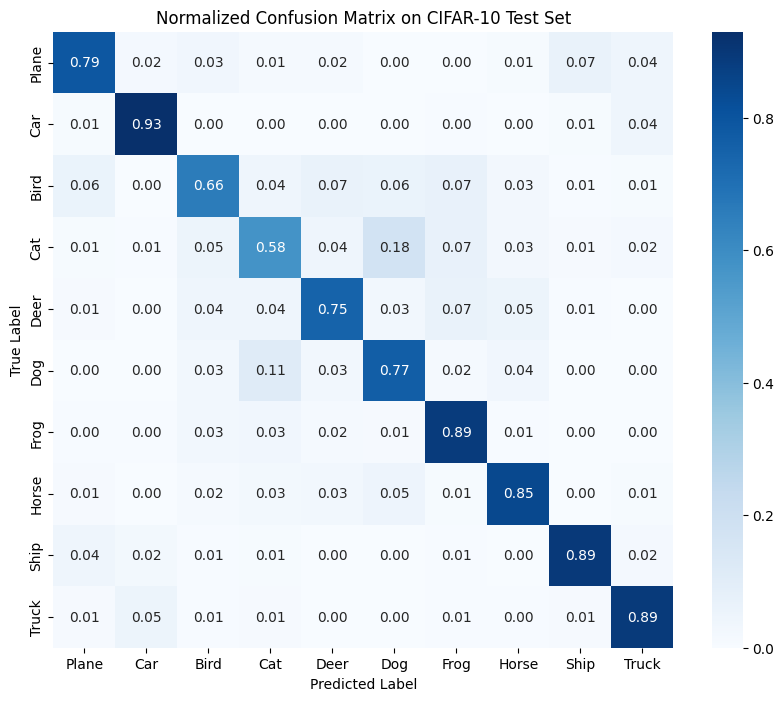

In [10]:
# Run evaluation
avg_test_loss, test_accuracy, class_accuracies, conf_matrix = evaluate_model_on_test_with_class_accuracy(alexnet, testloader)

# Print results
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print("Accuracy per class:")
for classname, accuracy in class_accuracies.items():
    print(f"{classname}: {accuracy:.2f}%")

# Plotting class accuracies
class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']  # CIFAR-10 class names
accuracies = list(class_accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class on CIFAR-10 Test Set')

# Add percentage labels on top of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f"{accuracy:.1f}%", ha='center', va='bottom', color='black')

plt.ylim(0, 100)  # Set y-axis from 0 to 100 for percentage
plt.xticks(rotation=45)
plt.show()

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1, keepdims=True), annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix on CIFAR-10 Test Set")
plt.show()